<div style='width: 750px; margin-left: 30px;'><h3>A quick introduction, and playground for Multi-armed Bandit Problems/Algorithms</h3>
<br />
<div style='font-size:16px; font-family:Sans-Serif;'>

<h4>Base case</h4>
<ul style='margin-left:30px'>
<li>There is a set $\mathcal{A}$ of m actions (or arms) that is available to the agent.</li>
<li>Each action $a$ is associated with a reward distribution $\mathcal{R}^a$. </li>
<li>At each timestep $t$, the agent chooses an action $a_t \in \mathcal{A}$ and receives a reward $r_t \sim \mathcal{R}^{a_t}$.</li>
<li>The agent's goal is to maximize total reward: $ \sum_{t=1}^T r_t$.</li>
</ul> <br />
The last statement is equivalent to minimizing regret, where we define regret as the difference between the reward asscoaited with the best possible action at step $t$, and the reward that was actually received: $l_t=\max\limits_{a_t \in \mathcal{A}}\mathbf{E}[r_t|a_t]-r_t$
<p></p>
</div>
</div>

In [1]:
from bandits.environment import BaseArm, Environment
from bandits.agents import RandomAgent, EpsilonGreedyAgent, UCB1Agent
from bandits.helpers import *
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

/Users/edenovitzer/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


<h4>Four normals with different expected/variance.</h4> <br />
$
\begin{align}
\mathcal{R_1} &\sim \mathcal{N}(20, 5)\\
\mathcal{R_2} &\sim \mathcal{N}(15, 10)\\
\mathcal{R_3} &\sim \mathcal{N}(20, 25)\\
\mathcal{R_4} &\sim \mathcal{N}(30, 15)
\end{align}
$

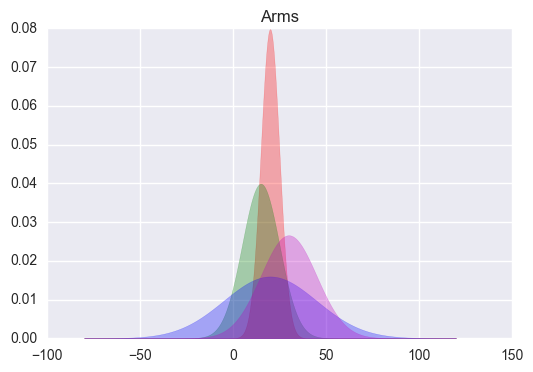

In [2]:
params = [(20, 5), (15, 10), (20, 25), (30, 15)]
arms = [BaseArm(norm(u, s)) for u, s in params]
env = Environment(arms)

x = np.linspace(-80, 120, 1000)
for (mu, s), c in zip(params, ['r', 'g', 'b', 'm']):
    plt.fill_between(x, norm.pdf(x, mu, s), alpha=0.3, color=c)
plt.title("Arms")
plt.show()

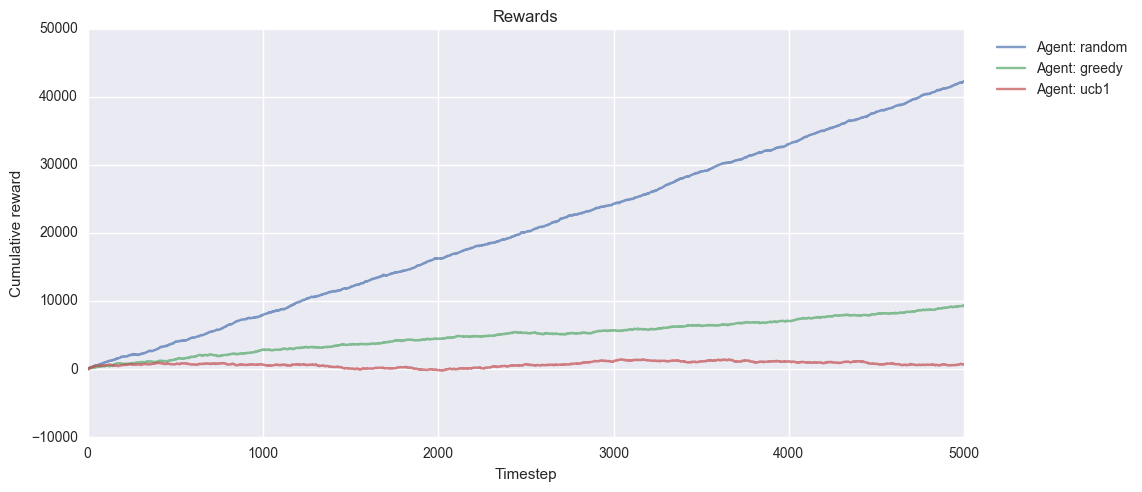

In [3]:
agents = {"random": RandomAgent(env),
          "greedy": EpsilonGreedyAgent(env, 0.2),
          "ucb1": UCB1Agent(env)}

r name, agent in agents.items():
    

random = RandomAgent(env)
greedy = EpsilonGreedyAgent(env, 0.2)
ucb1 = UCB1Agent(env)
T = 5000

random_choices, random_opt_rewards = random.play(T)
greedy_choices, greedy_opt_rewards = greedy.play(T)
ucb1_choices, ucb1_opt_rewards = ucb1.play(T)
plot_rewards({"random": (random_choices, random_opt_rewards),
              "greedy": (greedy_choices, greedy_opt_rewards),
              "ucb1" : (ucb1_choices, ucb1_opt_rewards)})

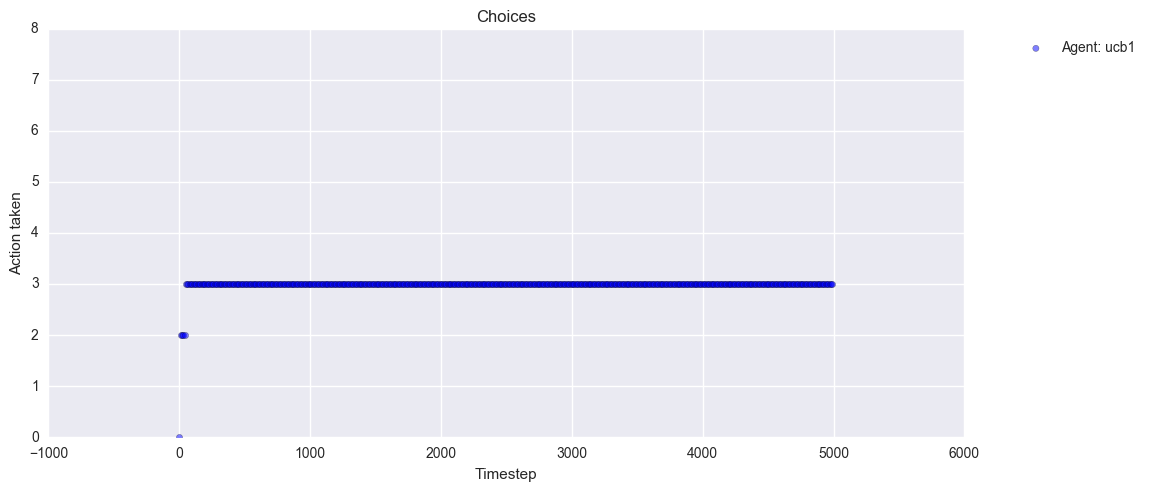

In [4]:
plot_choices({"ucb1": (ucb1_choices, ucb1_opt_rewards)})